In [3]:
%matplotlib inline
import sys
sys.version

'3.7.9 (default, Jan 24 2021, 23:57:56) \n[GCC 10.2.0]'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize
import json
from matplotlib.ticker import MaxNLocator

In [251]:
filename = "../../../results/2021-06-02T15:10:36_inv_2cpus_30000_20_90000_30000_80.json"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

ps = filename.split("_")
trps = dotdict({
    'p0': int(ps[3])/1000,
    'p0t': int(ps[4]),
    'p1': int(ps[5])/1000,
    'p2': int(ps[6])/1000,
    "p2t": int(ps[7].replace(".json", ""))
})

In [252]:
dict_for_colors = {}
get_counter_of_pid_list = []
available_colors = ['g','r','c','m','y','k']*1000000

def assign_color_to_hostname_pid(hostname, pid) -> str:
    key = hostname + pid
    if not key in dict_for_colors:
        dict_for_colors[key] = available_colors[len(dict_for_colors)]
    return dict_for_colors[key]

def get_counter_of_pid(pid) -> int:
    try:
        val =  get_counter_of_pid_list.index(pid)
        return val
    except Exception:
        get_counter_of_pid_list.append(pid)
        return get_counter_of_pid_list.index(pid)

In [253]:
with open(filename) as f:
    d = json.load(f)
data = json_normalize(d)

failed = [end == -1 for end in data['end']]
data.insert(0, "failed", failed)

min = data.start.min()
data.start = data.start - min
data.end = data.end - min
data['result.start_computation'] = data['result.start_computation'] - min
data['result.end_computation'] = data['result.end_computation'] - min
data['result.metadata.start'] = data['result.metadata.start'] - min
data['result.metadata.end'] = data['result.metadata.end'] - min

# End to End Latency
data.insert(0,"rlat",data.end - data.start)

# Distr
data.insert(0, "dlat", data.rlat - data['result.metadata.inference_ms'])

# (semi-)unique color per runtime instance
acc_color = [assign_color_to_hostname_pid(hostname, pid) for hostname,pid in zip(data['result.metadata.hostname'], data['result.pid'])]
data.insert(0,"acc_color", acc_color)

# unique id for every pid, starting with 0 (may be used as y-axis in some images)
inst_id = [get_counter_of_pid(pid) for pid in data['result.pid']]
data.insert(0, "inst_id", inst_id)

data.columns

Index(['inst_id', 'acc_color', 'dlat', 'rlat', 'failed', 'end', 'start',
       'inv.configuration', 'inv.params.callbackUrl', 'inv.params.payload',
       'inv.params.payload_reference.bucket.accessKey',
       'inv.params.payload_reference.bucket.bucketName',
       'inv.params.payload_reference.bucket.endpoint',
       'inv.params.payload_reference.bucket.secretKey',
       'inv.params.payload_reference.file', 'inv.params.payload_type',
       'inv.params.resultBucket.accessKey',
       'inv.params.resultBucket.bucketName',
       'inv.params.resultBucket.endpoint', 'inv.params.resultBucket.secretKey',
       'inv.runtime', 'result.accelerator', 'result.amount',
       'result.end_computation', 'result.metadata.inference_ms',
       'result.metadata.hostname', 'result.metadata.start',
       'result.metadata.end', 'result.pid', 'result.request', 'result.result',
       'result.result_type', 'result.start_computation', 'result'],
      dtype='object')

In [254]:
data['result.metadata.hostname']

0       localhost.localdomain
1              sandybridge-ep
2              sandybridge-ep
3              sandybridge-ep
4       localhost.localdomain
                ...          
7465                      NaN
7466                      NaN
7467                      NaN
7468                      NaN
7469                      NaN
Name: result.metadata.hostname, Length: 7470, dtype: object

In [255]:
print('Number of failed invocations:', len(data.loc[data['failed'] == True].index))
data.loc[data['failed'] == True]

Number of failed invocations: 1074


,inst_id,acc_color,dlat,rlat,failed,end,start,inv.configuration,inv.params.callbackUrl,inv.params.payload,...,result.metadata.inference_ms,result.metadata.hostname,result.metadata.start,result.metadata.end,result.pid,result.request,result.result,result.result_type,result.start_computation,result
1605,17,k,NaN,-1622639268408,True,-1622639206166,62242,test|tinyyolov2-7.onnx,localhost:3358/1gTUkaY8MA,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1756,17,g,NaN,-1622639272183,True,-1622639206166,66017,test|tinyyolov2-7.onnx,localhost:3358/Sv5miH6PRu,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1866,17,r,NaN,-1622639274392,True,-1622639206166,68226,test|tinyyolov2-7.onnx,localhost:3358/pExClTfm7E,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2031,17,c,NaN,-1622639278184,True,-1622639206166,72018,test|tinyyolov2-7.onnx,localhost:3358/sCyQigeLvE,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2036,17,m,NaN,-1622639278209,True,-1622639206166,72043,test|tinyyolov2-7.onnx,localhost:3358/F0db91TvgA,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7465,17,g,NaN,-1622639356380,True,-1622639206166,150214,test|tinyyolov2-7.onnx,localhost:3358/1EQj8w0cb3,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7466,17,r,NaN,-1622639356379,True,-1622639206166,150213,test|tinyyolov2-7.onnx,localhost:3358/wmG4UkX3Fl,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7467,17,c,NaN,-1622639356387,True,-1622639206166,150221,test|tinyyolov2-7.onnx,localhost:3358/wy1pfm1uVt,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7468,17,m,NaN,-1622639356387,True,-1622639206166,150221,test|tinyyolov2-7.onnx,localhost:3358/4iBxvDbMmV,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [256]:
data = data.loc[data['failed'] == False]

Used Runtime Instances and when they were active


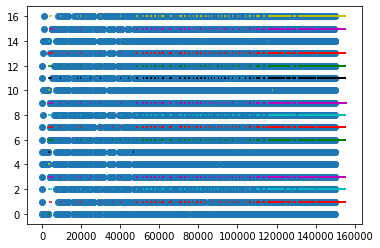

In [257]:
#plt.hlines(y=[i-0.2 for i in pid_counter], xmin=invokes, xmax=ends)
plt.hlines(y=data.inst_id, xmin=data['result.start_computation'], xmax=data['result.end_computation'], colors=data.acc_color, linestyle="solid")
plt.scatter(data.start, data.inst_id)
print("Used Runtime Instances and when they were active")

y=sequentially numbered invocations; blueDot=creation timestamp of invocation; line=working time (color=pid-code)


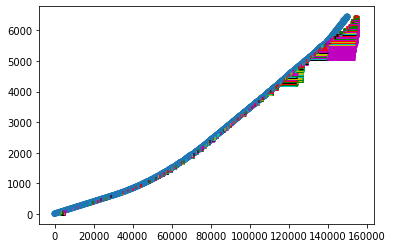

In [258]:
plt.scatter(data.start, data.index, alpha=0.3, linewidths=0.2, edgecolors='none')
plt.hlines(y=data.index, xmin=data['result.start_computation'], xmax=data['result.end_computation'], color=data.acc_color, lw=3)
print("y=sequentially numbered invocations; blueDot=creation timestamp of invocation; line=working time (color=pid-code)")

<AxesSubplot:ylabel='Requests [#]'>

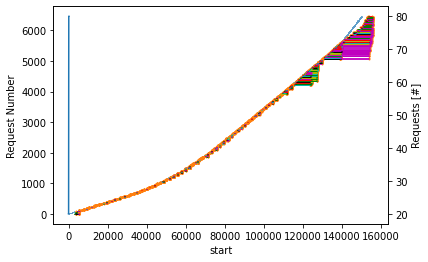

In [259]:
s = 0.9

fig = plt.figure()
ax = plt.axes()
ax.set_ylabel("Request Number")

sns.scatterplot(data=data, x='start', y=data.index, s=s)
plt.hlines(y=data.index, xmin=data['result.start_computation'], xmax=data['result.end_computation'], color=data['acc_color'], lw=s)
plt.scatter(data.end, data.index, s=s)

ax2 = ax.twinx()
ax2.set_ylabel("Requests [#]")
#sns.scatterplot(ax=ax2, data=dat, x=seconds.index, y='rsuccess', label="RSuccess")
sns.lineplot(ax=ax2, x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t])
#ax2.get_legend().remove()
#ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

#fig.legend(loc="upper right", bbox_to_anchor=(1.2, 0.8))

In [260]:
def print_stats(df):
    inf = df['result.metadata.inference_ms']
    print(f'Inference: mean={inf.mean()}, std={inf.std()}')
    print(f'Total Duration: mean={df.rlat.mean()}, std={df.rlat.std()}')
    com = df['result.end_computation'] - df['result.start_computation']
    print(f'Total Computation (inference+upload): mean={com.mean()}, std={com.std()}')
    tts = df['result.start_computation'] - df.start
    print(f'Time from invocation to start_computation: mean={tts.mean()}, std={tts.std()}')
    print()

print('results total: ')
print_stats(data)
print('results tubserver: ')
print_stats(data.loc[data['result.metadata.hostname'] == 'sandybridge-ep'])
print('results home: ')
print_stats(data.loc[data['result.metadata.hostname'] != 'sandybridge-ep'])

results total: 
Inference: mean=0.0019180469023875701, std=0.0009533206391384015
Total Duration: mean=2396.42464040025, std=3434.3225333797886
Total Computation (inference+upload): mean=1408.4552845528456, std=2925.4312950593803
Time from invocation to start_computation: mean=985.4208880550344, std=1126.3531131798215

results tubserver: 
Inference: mean=0.001694158686354123, std=0.0009816651034138047
Total Duration: mean=2992.574049217002, std=3890.4942755945017
Total Computation (inference+upload): mean=2006.8599552572707, std=3324.5296839817793
Time from invocation to start_computation: mean=983.7897091722596, std=1129.9231094348265

results home: 
Inference: mean=0.0024376628554870034, std=0.0006288294901056352
Total Duration: mean=1012.8380062305296, std=1141.4652896652706
Total Computation (inference+upload): mean=19.63447559709242, std=102.38375650087934
Time from invocation to start_computation: mean=989.2066458982347, std=1118.3067343446003



In [261]:
# Plot by RStart
#max = int(data.start.max() / 1000) # Rounds down to the latest second
#min = 0 # Per definition for the start
# Plot by EStart
max = int(data['result.start_computation'].max() / 1000)
min = int(data['result.start_computation'].min() / 1000)

seconds_d = {
    # Request-Response Latency
    'rlat_min': [],
    'rlat_med': [],
    'rlat_max': [],
    # Execution Start-End Latency
    'elat_min': [],
    'elat_med': [],
    'elat_max': [],
    # Number of successful invocations
    'rsuccess': []
}

for i in range(min, max):
    t_min = i * 1000
    t_max = (i+1) * 1000
    # For Host Selection:
    # (data['result.metadata.hostname'] != 'sandybridge-ep') & 
    # Plot by RStart
    #curr = data.loc[(data.start >= t_min) & (data.start < t_max)]
    # Plot by EStart
    curr = data.loc[(data['result.start_computation'] >= t_min) & (data['result.start_computation'] < t_max)]
    seconds_d['rlat_min'].append(curr.rlat.min())
    seconds_d['rlat_med'].append(curr.rlat.median())
    seconds_d['rlat_max'].append(curr.rlat.max())
    
    seconds_d['elat_min'].append(curr['result.metadata.inference_ms'].min())
    seconds_d['elat_med'].append(curr['result.metadata.inference_ms'].median())
    seconds_d['elat_max'].append(curr['result.metadata.inference_ms'].max())
    
    seconds_d['rsuccess'].append(len(curr.loc[curr['failed'] == False].index)) 
    
seconds = pd.DataFrame(seconds_d)

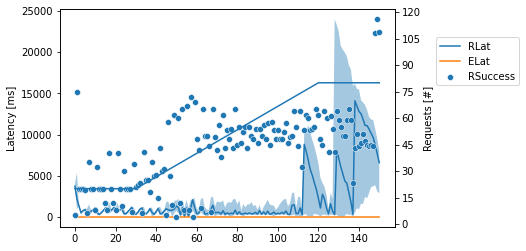

In [262]:
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel("Latency [ms]")
rlat = sns.lineplot(ax=ax, data=seconds, x=seconds.index, y='rlat_med', label="RLat")
elat = sns.lineplot(ax=ax, data=seconds, x=seconds.index, y='elat_med', label="ELat")
rlats = ax.fill_between(x=seconds.index, y1=seconds['rlat_min'], y2=seconds['rlat_max'], alpha=0.4)
elats = ax.fill_between(x=seconds.index, y1=seconds['elat_min'], y2=seconds['elat_max'], alpha=0.4)
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.set_ylabel("Requests [#]")
sns.scatterplot(ax=ax2, data=seconds, x=seconds.index, y='rsuccess', label="RSuccess")
sns.lineplot(ax=ax2, x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t])
ax2.get_legend().remove()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.legend(loc="upper right", bbox_to_anchor=(1.2, 0.8))

In [263]:
data['result.start_computation'].min()

2790.0